In [25]:
# 텍스트 임베딩 생성

## 1. 라이브러리 불러오기

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

print("기본 라이브러리 로드 완료")

기본 라이브러리 로드 완료


In [26]:
## 2. 전처리된 데이터 로드

# 데이터 경로 설정
PROCESSED_DIR = "./data/processed"
EMBEDDINGS_DIR = "./data/embeddings"

# 디렉토리 생성
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

# 필요한 데이터 파일 로드
data_files = {
    'interaction_df': 'interaction_df.pkl',
    'train_df': 'train_df.pkl',
    'val_df': 'val_df.pkl',
    'test_df': 'test_df.pkl',
    'train_with_neg': 'train_with_neg.pkl',
    'user_processed': 'user_processed.pkl',
    'business_processed': 'business_processed.pkl',
    'tip_processed': 'tip_processed.pkl',
    'user_to_idx': 'user_to_idx.pkl',
    'idx_to_user': 'idx_to_user.pkl',
    'business_to_idx': 'business_to_idx.pkl',
    'idx_to_business': 'idx_to_business.pkl'
}

# 데이터 로드
data = {}
for name, file in data_files.items():
    with open(os.path.join(PROCESSED_DIR, file), 'rb') as f:
        data[name] = pickle.load(f)
    print(f"{name} 로드 완료")

# 데이터 변수에 할당
interaction_df = data['interaction_df']
train_df = data['train_df']
val_df = data['val_df']
test_df = data['test_df']
train_with_neg = data['train_with_neg']
user_processed = data['user_processed']
business_processed = data['business_processed']
tip_processed = data['tip_processed']
user_to_idx = data['user_to_idx']
idx_to_user = data['idx_to_user']
business_to_idx = data['business_to_idx']
idx_to_business = data['idx_to_business']

print(f"훈련 세트 크기: {len(train_df):,}")
print(f"검증 세트 크기: {len(val_df):,}")
print(f"테스트 세트 크기: {len(test_df):,}")
print(f"리뷰 텍스트 샘플: {interaction_df['clean_text'].iloc[0][:100]}...")


interaction_df 로드 완료
train_df 로드 완료
val_df 로드 완료
test_df 로드 완료
train_with_neg 로드 완료
user_processed 로드 완료
business_processed 로드 완료
tip_processed 로드 완료
user_to_idx 로드 완료
idx_to_user 로드 완료
business_to_idx 로드 완료
idx_to_business 로드 완료
훈련 세트 크기: 20,674
검증 세트 크기: 4,128
테스트 세트 크기: 1,748
리뷰 텍스트 샘플: good food loved the gnocchi with marinara the baked eggplant appetizer was very good too the service...


In [27]:
## 3. 텍스트 임베딩 방식 설정

# 설정값
EMBEDDING_TYPE = "bert"  # 또는 "word2vec"
MAX_LEN = 256  # 시퀀스 최대 길이
EMBED_DIM = 768  # BERT 기본 임베딩 차원
REDUCED_DIM = 256  # 차원 축소 후 차원 (계산 효율성을 위해)
BATCH_SIZE = 16  # 배치 크기
USE_GPU = torch.cuda.is_available()  # GPU 사용 여부

print(f"임베딩 타입: {EMBEDDING_TYPE}")
print(f"최대 길이: {MAX_LEN}")
print(f"임베딩 차원: {EMBED_DIM}")
print(f"차원 축소 후 차원: {REDUCED_DIM}")
print(f"GPU 사용 가능: {USE_GPU}")

임베딩 타입: bert
최대 길이: 256
임베딩 차원: 768
차원 축소 후 차원: 256
GPU 사용 가능: True


In [ ]:
## 4. BERT 임베딩 함수 구현

# BERT 관련 라이브러리 설치 및 임포트
try:
    from transformers import BertTokenizer, BertModel
    print("Transformers 라이브러리가 이미 설치되어 있습니다.")
except ImportError:
    print("Transformers 라이브러리를 설치합니다...")
    %pip install -q transformers
    from transformers import BertTokenizer, BertModel
    print("Transformers 라이브러리 설치 완료.")

def create_bert_embeddings(texts, batch_size=16, max_length=256, model_name="bert-base-uncased", device=None):
    """
    텍스트 리스트를 BERT 임베딩으로 변환
    
    Args:
        texts (list): 임베딩할 텍스트 리스트
        batch_size (int): 배치 크기
        max_length (int): 최대 토큰 길이
        model_name (str): 사용할 BERT 모델 이름
        device (str): 사용할 장치 ('cuda' 또는 'cpu')
        
    Returns:
        np.ndarray: 텍스트 임베딩 (texts_count x embed_dim)
    """
    # 장치 설정
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 토크나이저 및 모델 로드
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)
    model.eval()
    
    # 결과 저장을 위한 리스트
    all_embeddings = []
    
    # 배치 단위로 처리
    for i in tqdm(range(0, len(texts), batch_size), desc="BERT 임베딩 생성"):
        batch_texts = texts[i:i+batch_size]
        
        # 빈 텍스트 처리
        batch_texts = [text if isinstance(text, str) and text.strip() else "" for text in batch_texts]
        
        # 토큰화
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(device)
        
        # 임베딩 생성
        with torch.no_grad():
            outputs = model(**inputs)
            
            # [CLS] 토큰의 마지막 히든 스테이트 사용 (문장 전체 표현)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(embeddings)
    
    # 모든 임베딩 결합
    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings


Transformers 라이브러리가 이미 설치되어 있습니다.


In [ ]:
## 5. Word2Vec 임베딩 함수 구현 (대체 접근법)

# Word2Vec 관련 라이브러리 설치 및 임포트
try:
    import nltk
    from gensim.models import Word2Vec
    from nltk.tokenize import word_tokenize
    print("Gensim 및 NLTK 라이브러리가 이미 설치되어 있습니다.")
except ImportError:
    print("Gensim 및 NLTK 라이브러리를 설치합니다...")
    %pip install -q gensim nltk
    import nltk
    from gensim.models import Word2Vec
    from nltk.tokenize import word_tokenize
    print("Gensim 및 NLTK 라이브러리 설치 완료.")
    
# NLTK 데이터 다운로드
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt 토크나이저가 이미 설치되어 있습니다.")
except LookupError:
    print("NLTK punkt 토크나이저를 다운로드합니다...")
    nltk.download('punkt')
    print("NLTK punkt 토크나이저 다운로드 완료.")

def create_word2vec_embeddings(texts, vector_size=100, window=5, min_count=1):
    """
    텍스트 리스트를 Word2Vec 임베딩으로 변환
    
    Args:
        texts (list): 임베딩할 텍스트 리스트
        vector_size (int): 벡터 크기
        window (int): 컨텍스트 윈도우 크기
        min_count (int): 최소 단어 빈도
        
    Returns:
        tuple: (텍스트 임베딩 배열, Word2Vec 모델)
    """
    # 텍스트 토큰화
    tokenized_texts = []
    for text in tqdm(texts, desc="텍스트 토큰화"):
        if isinstance(text, str) and text.strip():
            tokenized_texts.append(word_tokenize(text.lower()))
        else:
            tokenized_texts.append([])
    
    # Word2Vec 모델 학습
    print("Word2Vec 모델 학습 중...")
    model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4
    )
    print("Word2Vec 모델 학습 완료.")
    
    # 텍스트별 임베딩 생성 (단어 벡터의 평균)
    embeddings = []
    for tokens in tqdm(tokenized_texts, desc="텍스트 임베딩 생성"):
        if tokens:
            # 모델에 있는 토큰만 사용
            valid_tokens = [token for token in tokens if token in model.wv]
            if valid_tokens:
                # 단어 벡터의 평균 계산
                embedding = np.mean([model.wv[token] for token in valid_tokens], axis=0)
            else:
                # 유효한 토큰이 없으면 0 벡터 사용
                embedding = np.zeros(vector_size)
        else:
            # 빈 텍스트는 0 벡터 사용
            embedding = np.zeros(vector_size)
        embeddings.append(embedding)
    
    return np.array(embeddings), model

Gensim 및 NLTK 라이브러리가 이미 설치되어 있습니다.
NLTK punkt 토크나이저가 이미 설치되어 있습니다.


In [30]:
## 6. 리뷰 텍스트 임베딩 생성

# 훈련 세트의 리뷰 텍스트 임베딩 생성
if EMBEDDING_TYPE == "bert":
    print("BERT 임베딩 생성 중...")
    train_review_embeddings = create_bert_embeddings(
        train_df['clean_text'].tolist(),
        batch_size=BATCH_SIZE,
        max_length=MAX_LEN,
        device='cuda' if USE_GPU else 'cpu'
    )
    print(f"훈련 리뷰 임베딩 크기: {train_review_embeddings.shape}")
    
    # 검증 세트의 리뷰 텍스트 임베딩 생성
    val_review_embeddings = create_bert_embeddings(
        val_df['clean_text'].tolist(),
        batch_size=BATCH_SIZE,
        max_length=MAX_LEN,
        device='cuda' if USE_GPU else 'cpu'
    )
    print(f"검증 리뷰 임베딩 크기: {val_review_embeddings.shape}")
    
    # 테스트 세트의 리뷰 텍스트 임베딩 생성
    test_review_embeddings = create_bert_embeddings(
        test_df['clean_text'].tolist(),
        batch_size=BATCH_SIZE,
        max_length=MAX_LEN,
        device='cuda' if USE_GPU else 'cpu'
    )
    print(f"테스트 리뷰 임베딩 크기: {test_review_embeddings.shape}")
else:
    print("Word2Vec 임베딩 생성 중...")
    # 모든 훈련 텍스트로 Word2Vec 모델 학습
    all_texts = train_df['clean_text'].tolist() + val_df['clean_text'].tolist() + test_df['clean_text'].tolist()
    all_embeddings, word2vec_model = create_word2vec_embeddings(
        all_texts,
        vector_size=100
    )
    
    # 세트별로 임베딩 분리
    train_size = len(train_df)
    val_size = len(val_df)
    test_size = len(test_df)
    
    train_review_embeddings = all_embeddings[:train_size]
    val_review_embeddings = all_embeddings[train_size:train_size+val_size]
    test_review_embeddings = all_embeddings[train_size+val_size:]
    
    print(f"훈련 리뷰 임베딩 크기: {train_review_embeddings.shape}")
    print(f"검증 리뷰 임베딩 크기: {val_review_embeddings.shape}")
    print(f"테스트 리뷰 임베딩 크기: {test_review_embeddings.shape}")

BERT 임베딩 생성 중...


BERT 임베딩 생성: 100%|██████████| 1293/1293 [02:27<00:00,  8.75it/s]


훈련 리뷰 임베딩 크기: (20674, 768)


BERT 임베딩 생성: 100%|██████████| 258/258 [00:30<00:00,  8.45it/s]


검증 리뷰 임베딩 크기: (4128, 768)


BERT 임베딩 생성: 100%|██████████| 110/110 [00:13<00:00,  8.28it/s]

테스트 리뷰 임베딩 크기: (1748, 768)


In [31]:
## 7. 팁 텍스트 임베딩 생성 (추가 데이터)

# 팁 텍스트 임베딩 생성
if len(tip_processed) > 0:
    if EMBEDDING_TYPE == "bert":
        print("팁 BERT 임베딩 생성 중...")
        tip_embeddings = create_bert_embeddings(
            tip_processed['clean_text'].tolist(),
            batch_size=BATCH_SIZE,
            max_length=MAX_LEN,
            device='cuda' if USE_GPU else 'cpu'
        )
    else:
        print("팁 Word2Vec 임베딩 생성 중...")
        tip_embeddings, _ = create_word2vec_embeddings(
            tip_processed['clean_text'].tolist(),
            vector_size=100
        )
    
    print(f"팁 임베딩 크기: {tip_embeddings.shape}")
else:
    print("팁 데이터가 없거나 비어 있습니다.")
    tip_embeddings = np.array([])

팁 BERT 임베딩 생성 중...


BERT 임베딩 생성: 100%|██████████| 33/33 [00:00<00:00, 50.27it/s]

팁 임베딩 크기: (515, 768)


In [32]:
## 8. 차원 축소 적용 (선택적)

def reduce_dimensions(embeddings, method='pca', n_components=256, random_state=42):
    """
    고차원 임베딩을 저차원으로 축소
    
    Args:
        embeddings (np.ndarray): 임베딩 배열
        method (str): 차원 축소 방법 ('pca' 또는 'tsne')
        n_components (int): 축소 후 차원 수
        random_state (int): 랜덤 시드
        
    Returns:
        np.ndarray: 축소된 임베딩
    """
    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=random_state)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=random_state)
    else:
        raise ValueError("지원되지 않는 차원 축소 방법입니다. 'pca' 또는 'tsne'를 사용하세요.")
    
    print(f"{method.upper()} 차원 축소 적용 중 ({embeddings.shape[1]} -> {n_components})...")
    reduced_embeddings = reducer.fit_transform(embeddings)
    print(f"차원 축소 완료: {reduced_embeddings.shape}")
    
    if method == 'pca':
        # 설명된 분산 비율 출력
        explained_variance = reducer.explained_variance_ratio_.sum()
        print(f"설명된 분산 비율: {explained_variance:.4f}")
    
    return reduced_embeddings

# BERT 임베딩인 경우 차원 축소 적용
if EMBEDDING_TYPE == "bert" and REDUCED_DIM < EMBED_DIM:
    # 훈련 세트 리뷰 임베딩 차원 축소
    train_review_embeddings_reduced = reduce_dimensions(
        train_review_embeddings,
        method='pca',
        n_components=REDUCED_DIM
    )
    
    # 검증 세트 리뷰 임베딩 차원 축소
    val_review_embeddings_reduced = reduce_dimensions(
        val_review_embeddings,
        method='pca',
        n_components=REDUCED_DIM
    )
    
    # 테스트 세트 리뷰 임베딩 차원 축소
    test_review_embeddings_reduced = reduce_dimensions(
        test_review_embeddings,
        method='pca',
        n_components=REDUCED_DIM
    )
    
    # 팁 임베딩 차원 축소
    if len(tip_embeddings) > 0:
        tip_embeddings_reduced = reduce_dimensions(
            tip_embeddings,
            method='pca',
            n_components=REDUCED_DIM
        )
    else:
        tip_embeddings_reduced = np.array([])
else:
    # 차원 축소를 적용하지 않는 경우 원본 임베딩 사용
    train_review_embeddings_reduced = train_review_embeddings
    val_review_embeddings_reduced = val_review_embeddings
    test_review_embeddings_reduced = test_review_embeddings
    tip_embeddings_reduced = tip_embeddings

PCA 차원 축소 적용 중 (768 -> 256)...
차원 축소 완료: (20674, 256)
설명된 분산 비율: 0.9226
PCA 차원 축소 적용 중 (768 -> 256)...
차원 축소 완료: (4128, 256)
설명된 분산 비율: 0.9281
PCA 차원 축소 적용 중 (768 -> 256)...
차원 축소 완료: (1748, 256)
설명된 분산 비율: 0.9378
PCA 차원 축소 적용 중 (768 -> 256)...
차원 축소 완료: (515, 256)
설명된 분산 비율: 0.9719


t-SNE 적용 중 (perplexity=30)...


C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\

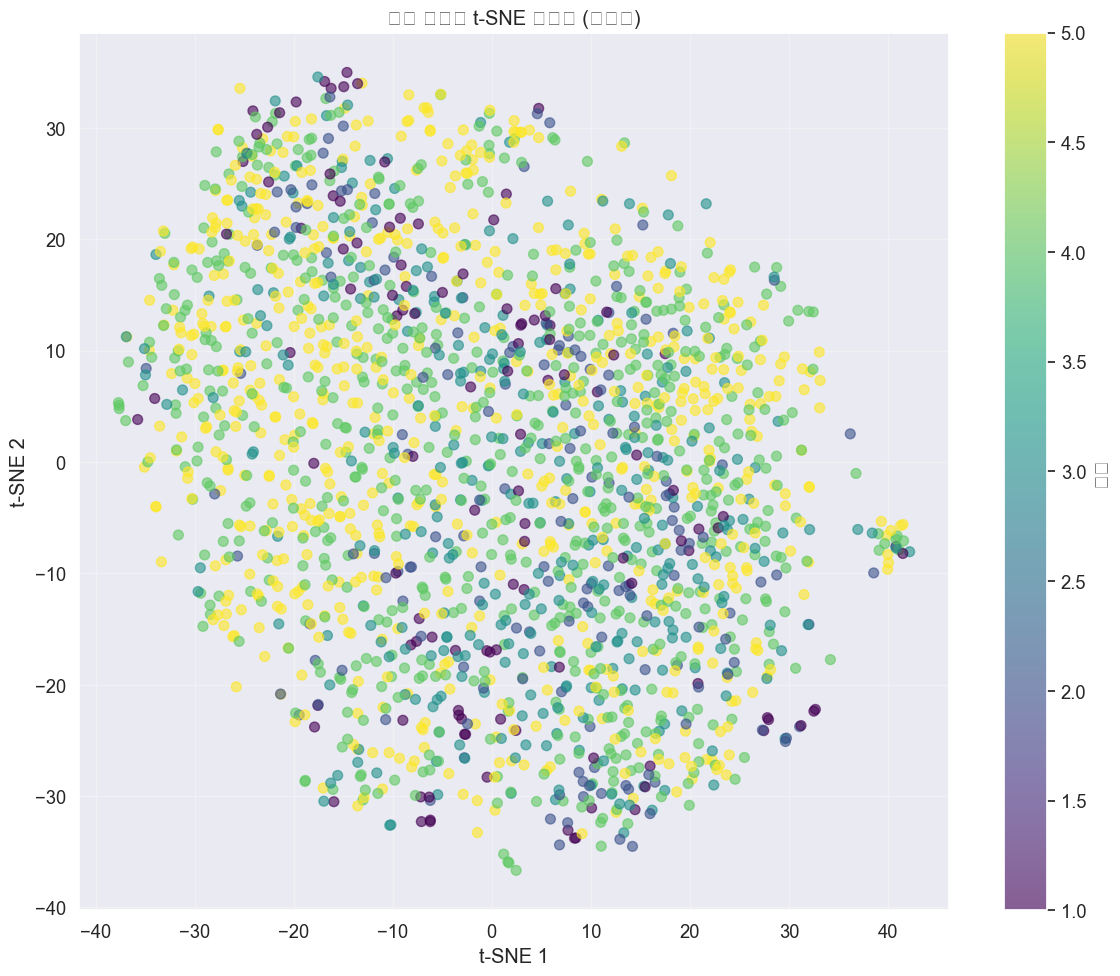

t-SNE 적용 중 (perplexity=15)...


C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_13204\725524886.py:62: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\

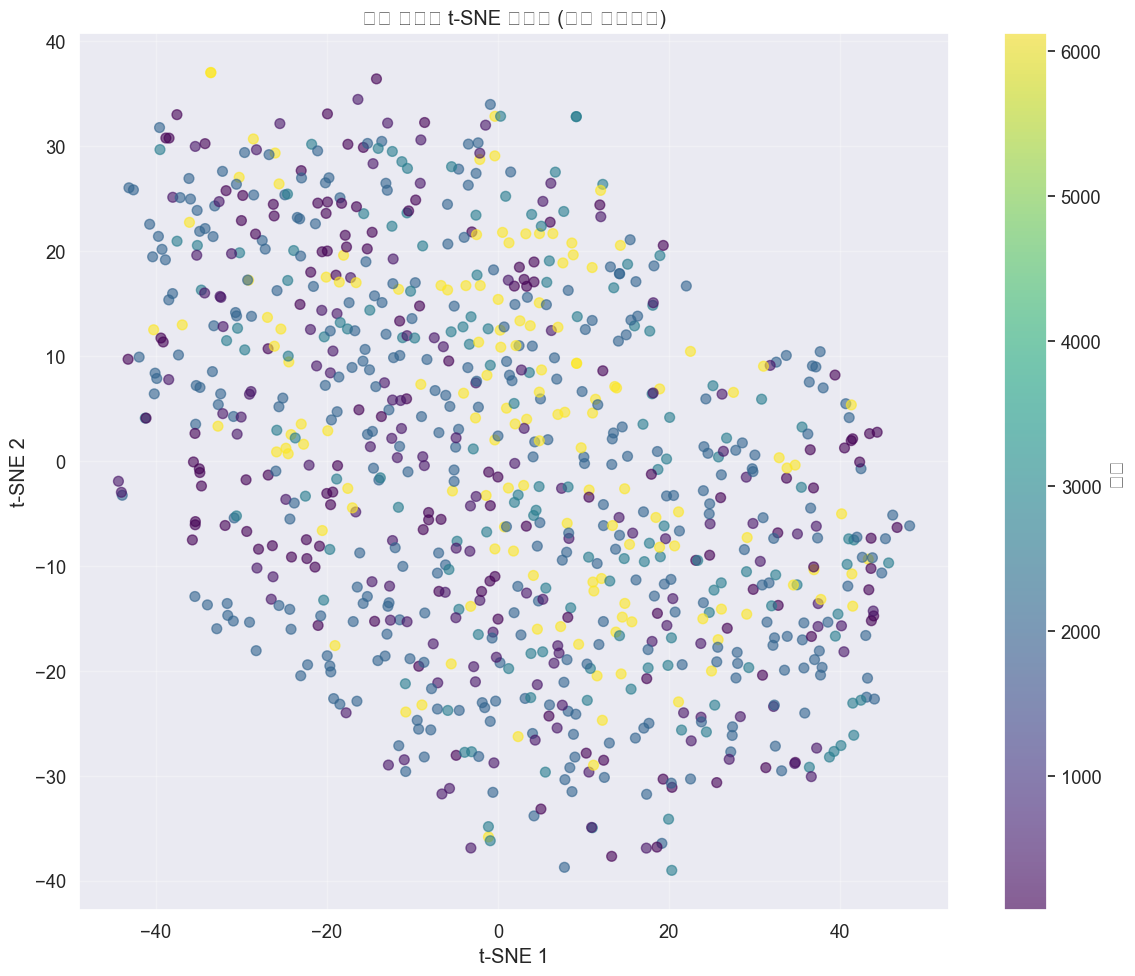

In [33]:
## 9. 임베딩 시각화 (t-SNE)

def visualize_embeddings(embeddings, labels, n_samples=1000, perplexity=30, title="임베딩 시각화"):
    """
    t-SNE를 사용하여 임베딩 시각화
    
    Args:
        embeddings (np.ndarray): 임베딩 배열
        labels (pd.Series): 레이블 (예: 평점, 카테고리 등)
        n_samples (int): 시각화할 샘플 수
        perplexity (int): t-SNE 매개변수
        title (str): 시각화 제목
    """
    # 샘플 선택
    if len(embeddings) > n_samples:
        indices = np.random.choice(len(embeddings), n_samples, replace=False)
        embeddings_sample = embeddings[indices]
        labels_sample = labels.iloc[indices] if isinstance(labels, pd.Series) else labels[indices]
    else:
        embeddings_sample = embeddings
        labels_sample = labels
    
    # t-SNE 적용
    print(f"t-SNE 적용 중 (perplexity={perplexity})...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_sample)
    
    # 시각화
    plt.figure(figsize=(12, 10))
    
    # 레이블이 숫자(평점)인 경우 스캐터 플롯 사용
    if np.issubdtype(np.array(labels_sample).dtype, np.number):
        scatter = plt.scatter(
            embeddings_2d[:, 0], 
            embeddings_2d[:, 1], 
            c=labels_sample, 
            cmap='viridis', 
            alpha=0.6,
            s=50
        )
        plt.colorbar(scatter, label='평점')
    # 레이블이 카테고리인 경우 다른 색상으로 표시
    else:
        unique_labels = np.unique(labels_sample)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        
        for i, label in enumerate(unique_labels):
            mask = labels_sample == label
            plt.scatter(
                embeddings_2d[mask, 0], 
                embeddings_2d[mask, 1], 
                color=colors[i], 
                label=label,
                alpha=0.6,
                s=50
            )
        plt.legend(title='카테고리')
    
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

# 임베딩 시각화 (평점별)
visualize_embeddings(
    train_review_embeddings_reduced,
    train_df['rating'],
    n_samples=2000,
    perplexity=30,
    title="리뷰 임베딩 t-SNE 시각화 (평점별)"
)

# 상위 아이템 카테고리 추출
top_items = train_df['item_idx'].value_counts().head(5).index.tolist()
top_items_mask = train_df['item_idx'].isin(top_items)
top_items_embeddings = train_review_embeddings_reduced[top_items_mask]
top_items_labels = train_df.loc[top_items_mask, 'item_idx']

# 인기 아이템별 시각화
visualize_embeddings(
    top_items_embeddings,
    top_items_labels,
    perplexity=15,
    title="리뷰 임베딩 t-SNE 시각화 (인기 아이템별)"
)

In [34]:
## 10. 아이템별 임베딩 생성 (리뷰 임베딩 평균)

def create_item_embeddings(interaction_df, review_embeddings, item_ids):
    """
    아이템별 임베딩 생성 (해당 아이템의 모든 리뷰 임베딩 평균)
    
    Args:
        interaction_df (pd.DataFrame): 상호작용 데이터프레임
        review_embeddings (np.ndarray): 리뷰 임베딩 배열
        item_ids (list): 아이템 ID 리스트
        
    Returns:
        dict: 아이템 ID를 키로, 임베딩 벡터를 값으로 하는 딕셔너리
    """
    item_embeddings = {}
    
    for item_idx in tqdm(item_ids, desc="아이템별 임베딩 생성"):
        # 해당 아이템의 리뷰 인덱스 찾기
        item_review_indices = interaction_df[interaction_df['item_idx'] == item_idx].index
        
        if len(item_review_indices) > 0:
            # 해당 아이템의 리뷰 임베딩 추출
            item_review_embeds = review_embeddings[item_review_indices]
            
            # 평균 임베딩 계산
            item_embedding = np.mean(item_review_embeds, axis=0)
        else:
            # 리뷰가 없는 경우 0 벡터 사용
            item_embedding = np.zeros(review_embeddings.shape[1])
        
        # 딕셔너리에 저장
        item_embeddings[item_idx] = item_embedding
    
    return item_embeddings

# 훈련 세트 아이템 임베딩 생성
train_items = train_df['item_idx'].unique()
train_item_embeddings = create_item_embeddings(train_df, train_review_embeddings_reduced, train_items)
print(f"훈련 아이템 임베딩 수: {len(train_item_embeddings)}")

# 임베딩 배열 형태로 변환
train_item_embeds_array = np.array([train_item_embeddings[idx] for idx in sorted(train_item_embeddings.keys())])
print(f"훈련 아이템 임베딩 배열 크기: {train_item_embeds_array.shape}")


아이템별 임베딩 생성: 100%|██████████| 3486/3486 [00:00<00:00, 3859.01it/s]

훈련 아이템 임베딩 수: 3486
훈련 아이템 임베딩 배열 크기: (3486, 256)


In [35]:
## 11. 사용자별 임베딩 생성 (사용자 리뷰 임베딩 평균)

def create_user_embeddings(interaction_df, review_embeddings, user_ids):
    """
    사용자별 임베딩 생성 (사용자가 작성한 모든 리뷰 임베딩 평균)
    
    Args:
        interaction_df (pd.DataFrame): 상호작용 데이터프레임
        review_embeddings (np.ndarray): 리뷰 임베딩 배열
        user_ids (list): 사용자 ID 리스트
        
    Returns:
        dict: 사용자 ID를 키로, 임베딩 벡터를 값으로 하는 딕셔너리
    """
    user_embeddings = {}
    
    for user_idx in tqdm(user_ids, desc="사용자별 임베딩 생성"):
        # 해당 사용자의 리뷰 인덱스 찾기
        user_review_indices = interaction_df[interaction_df['user_idx'] == user_idx].index
        
        if len(user_review_indices) > 0:
            # 해당 사용자의 리뷰 임베딩 추출
            user_review_embeds = review_embeddings[user_review_indices]
            
            # 평균 임베딩 계산
            user_embedding = np.mean(user_review_embeds, axis=0)
        else:
            # 리뷰가 없는 경우 0 벡터 사용
            user_embedding = np.zeros(review_embeddings.shape[1])
        
        # 딕셔너리에 저장
        user_embeddings[user_idx] = user_embedding
    
    return user_embeddings

# 훈련 세트 사용자 임베딩 생성
train_users = train_df['user_idx'].unique()
train_user_embeddings = create_user_embeddings(train_df, train_review_embeddings_reduced, train_users)
print(f"훈련 사용자 임베딩 수: {len(train_user_embeddings)}")

# 임베딩 배열 형태로 변환
train_user_embeds_array = np.array([train_user_embeddings[idx] for idx in sorted(train_user_embeddings.keys())])
print(f"훈련 사용자 임베딩 배열 크기: {train_user_embeds_array.shape}")

사용자별 임베딩 생성: 100%|██████████| 18129/18129 [00:04<00:00, 4151.70it/s]

훈련 사용자 임베딩 수: 18129
훈련 사용자 임베딩 배열 크기: (18129, 256)


In [36]:
## 12. 팁 데이터를 활용한 임베딩 보강 (선택적)

def enhance_item_embeddings_with_tips(item_embeddings, tip_df, tip_embeddings, weight=0.3):
    """
    팁 데이터를 활용하여 아이템 임베딩 보강
    
    Args:
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        tip_df (pd.DataFrame): 팁 데이터프레임
        tip_embeddings (np.ndarray): 팁 임베딩 배열
        weight (float): 팁 임베딩 가중치 (0-1 사이)
        
    Returns:
        dict: 보강된 아이템 임베딩 딕셔너리
    """
    enhanced_embeddings = item_embeddings.copy()
    
    # 팁 인덱스 재매핑 - DataFrame의 인덱스 값과 배열 인덱스를 연결
    tip_idx_map = {idx: i for i, idx in enumerate(tip_df.index)}
    
    for item_idx in tqdm(item_embeddings.keys(), desc="팁 임베딩으로 보강"):
        # 해당 아이템의 팁 인덱스 찾기
        item_tip_indices = tip_df[tip_df['item_idx'] == item_idx].index
        
        if len(item_tip_indices) > 0:
            # 팁 인덱스를 배열 인덱스로 변환
            mapped_indices = [tip_idx_map[idx] for idx in item_tip_indices if idx in tip_idx_map]
            
            if len(mapped_indices) > 0:
                # 해당 아이템의 팁 임베딩 추출
                item_tip_embeds = tip_embeddings[mapped_indices]
                
                # 평균 팁 임베딩 계산
                item_tip_embedding = np.mean(item_tip_embeds, axis=0)
                
                # 기존 리뷰 임베딩과 팁 임베딩을 가중 결합
                original_embedding = enhanced_embeddings[item_idx]
                enhanced_embeddings[item_idx] = (1 - weight) * original_embedding + weight * item_tip_embedding
    
    return enhanced_embeddings

In [37]:
## 13. 검증 및 테스트 세트의 아이템 및 사용자 임베딩 생성

# 검증 세트 아이템 및 사용자 임베딩 생성
val_items = val_df['item_idx'].unique()
val_users = val_df['user_idx'].unique()

val_item_embeddings = create_item_embeddings(val_df, val_review_embeddings_reduced, val_items)
val_user_embeddings = create_user_embeddings(val_df, val_review_embeddings_reduced, val_users)

print(f"검증 아이템 임베딩 수: {len(val_item_embeddings)}")
print(f"검증 사용자 임베딩 수: {len(val_user_embeddings)}")

# 테스트 세트 아이템 및 사용자 임베딩 생성
test_items = test_df['item_idx'].unique()
test_users = test_df['user_idx'].unique()

test_item_embeddings = create_item_embeddings(test_df, test_review_embeddings_reduced, test_items)
test_user_embeddings = create_user_embeddings(test_df, test_review_embeddings_reduced, test_users)

print(f"테스트 아이템 임베딩 수: {len(test_item_embeddings)}")
print(f"테스트 사용자 임베딩 수: {len(test_user_embeddings)}")


사용자별 임베딩 생성: 100%|██████████| 4118/4118 [00:00<00:00, 4735.23it/s]


검증 아이템 임베딩 수: 1806
검증 사용자 임베딩 수: 4118


사용자별 임베딩 생성: 100%|██████████| 1738/1738 [00:00<00:00, 4430.66it/s]

테스트 아이템 임베딩 수: 1106
테스트 사용자 임베딩 수: 1738


In [38]:
## 14. 임베딩 저장

# enhanced_item_embeddings가 정의되지 않은 경우 처리
if 'enhanced_item_embeddings' not in locals():
    print("enhanced_item_embeddings가 정의되지 않았습니다. train_item_embeddings를 대신 사용합니다.")
    enhanced_item_embeddings = train_item_embeddings

# 임베딩 저장
embeddings_to_save = {
    'train_review_embeddings': train_review_embeddings_reduced,
    'val_review_embeddings': val_review_embeddings_reduced,
    'test_review_embeddings': test_review_embeddings_reduced,
    'train_item_embeddings': train_item_embeddings,
    'val_item_embeddings': val_item_embeddings,
    'test_item_embeddings': test_item_embeddings,
    'train_user_embeddings': train_user_embeddings,
    'val_user_embeddings': val_user_embeddings,
    'test_user_embeddings': test_user_embeddings,
    'enhanced_item_embeddings': enhanced_item_embeddings
}

# tip_embeddings_reduced가 존재하는 경우에만 저장
if 'tip_embeddings_reduced' in locals() and len(tip_embeddings_reduced) > 0:
    embeddings_to_save['tip_embeddings'] = tip_embeddings_reduced
else:
    print("tip_embeddings_reduced가 정의되지 않았거나 비어 있습니다.")

for name, embedding in embeddings_to_save.items():
    file_path = os.path.join(EMBEDDINGS_DIR, f"{name}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(embedding, f)
    print(f"{name} 저장 완료: {file_path}")

train_review_embeddings 저장 완료: ./data/embeddings\train_review_embeddings.pkl
val_review_embeddings 저장 완료: ./data/embeddings\val_review_embeddings.pkl
test_review_embeddings 저장 완료: ./data/embeddings\test_review_embeddings.pkl
train_item_embeddings 저장 완료: ./data/embeddings\train_item_embeddings.pkl
val_item_embeddings 저장 완료: ./data/embeddings\val_item_embeddings.pkl
test_item_embeddings 저장 완료: ./data/embeddings\test_item_embeddings.pkl
train_user_embeddings 저장 완료: ./data/embeddings\train_user_embeddings.pkl
val_user_embeddings 저장 완료: ./data/embeddings\val_user_embeddings.pkl
test_user_embeddings 저장 완료: ./data/embeddings\test_user_embeddings.pkl
enhanced_item_embeddings 저장 완료: ./data/embeddings\enhanced_item_embeddings.pkl
tip_embeddings 저장 완료: ./data/embeddings\tip_embeddings.pkl


In [39]:
## 15. 임베딩 분석

# 아이템 임베딩 간 유사도 계산 (코사인 유사도)
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_items(item_idx, item_embeddings, business_data, top_n=5):
    """
    임베딩 유사도를 기반으로 유사한 아이템 찾기
    
    Args:
        item_idx (int): 기준 아이템 인덱스
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        business_data (pd.DataFrame): 비즈니스 데이터프레임
        top_n (int): 반환할 유사 아이템 수
        
    Returns:
        pd.DataFrame: 유사한 아이템 데이터프레임
    """
    if item_idx not in item_embeddings:
        print(f"경고: item_idx {item_idx}가 item_embeddings에 없습니다.")
        return pd.DataFrame(columns=['item_idx', 'name', 'stars', 'similarity'])
    
    # 기준 아이템 임베딩
    query_embedding = item_embeddings[item_idx].reshape(1, -1)
    
    # 모든 아이템 ID와 임베딩
    all_item_ids = list(item_embeddings.keys())
    all_embeddings = np.array([item_embeddings[idx] for idx in all_item_ids])
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(query_embedding, all_embeddings).flatten()
    
    # 유사도 기준 상위 아이템 인덱스 (자기 자신 제외)
    top_indices = np.argsort(similarities)[::-1][1:top_n+1]
    
    # 결과 데이터프레임 생성
    similar_items = []
    for idx in top_indices:
        similar_item_idx = all_item_ids[idx]
        
        # business_data에서 해당 아이템 정보 찾기
        item_data = business_data[business_data['item_idx'] == similar_item_idx]
        
        if len(item_data) > 0:
            # 데이터가 있으면 이름과 평점 추가
            name = item_data['name'].iloc[0] if 'name' in item_data.columns else "Unknown"
            stars = item_data['stars'].iloc[0] if 'stars' in item_data.columns else 0.0
            
            similar_items.append({
                'item_idx': similar_item_idx,
                'name': name,
                'stars': stars,
                'similarity': similarities[idx]
            })
        else:
            # 데이터가 없으면 기본값 사용
            similar_items.append({
                'item_idx': similar_item_idx,
                'name': f"Item #{similar_item_idx}",
                'stars': 0.0,
                'similarity': similarities[idx]
            })
    
    # 빈 목록이면 빈 DataFrame 반환
    if not similar_items:
        return pd.DataFrame(columns=['item_idx', 'name', 'stars', 'similarity'])
    
    return pd.DataFrame(similar_items)

popular_items = business_processed['item_idx'].value_counts().head(3).index.tolist()

for item_idx in popular_items:
    try:
        # 비즈니스 이름 가져오기
        item_rows = business_processed[business_processed['item_idx'] == item_idx]
        if len(item_rows) == 0:
            print(f"비즈니스 데이터에서 item_idx {item_idx}를 찾을 수 없습니다.")
            continue
            
        business_name = item_rows['name'].iloc[0]
        print(f"\n=== '{business_name}' 과 유사한 비즈니스 ===")
        
        # 유사 아이템 찾기
        similar_items = find_similar_items(
            item_idx, 
            enhanced_item_embeddings,  # 팁으로 보강된 임베딩 사용
            business_processed,
            top_n=5
        )
        
        # 결과 출력
        if not similar_items.empty:
            print(similar_items[['name', 'stars', 'similarity']])
        else:
            print("유사한 비즈니스를 찾을 수 없습니다.")
    except Exception as e:
        print(f"오류 발생: {str(e)}")
        import traceback
        traceback.print_exc()


=== 'St Honore Pastries' 과 유사한 비즈니스 ===
             name  stars  similarity
0   Papa Murphy's    4.0    0.627508
1   La Dolce Vita    4.0    0.588051
2     Häagen-Dazs    4.0    0.555644
3     Sam's Gyros    3.5    0.554829
4  Isabella Pizza    3.0    0.545338

=== 'Savannah Tea House' 과 유사한 비즈니스 ===
                  name  stars  similarity
0          Ellington's    4.0    0.624276
1              Brugada    3.5    0.557826
2  Athenian Restaurant    4.0    0.538580
3                Denim    4.0    0.531413
4       The Dog Saloon    4.5    0.526766

=== 'Fountain Restaurant' 과 유사한 비즈니스 ===
경고: item_idx 4769가 item_embeddings에 없습니다.
유사한 비즈니스를 찾을 수 없습니다.


In [40]:
## 16. 임베딩 품질 평가

# 임베딩 품질 평가 (같은 평점의 리뷰가 서로 더 유사한지 확인)
def evaluate_embedding_quality(review_embeddings, ratings, n_samples=1000):
    """
    임베딩 품질 평가 (같은 평점의 리뷰가 서로 더 유사한지 확인)
    
    Args:
        review_embeddings (np.ndarray): 리뷰 임베딩 배열
        ratings (pd.Series): 평점
        n_samples (int): 평가할 샘플 수
        
    Returns:
        tuple: (같은 평점 리뷰 간 평균 유사도, 다른 평점 리뷰 간 평균 유사도)
    """
    if len(review_embeddings) > n_samples:
        indices = np.random.choice(len(review_embeddings), n_samples, replace=False)
        embeddings_sample = review_embeddings[indices]
        ratings_sample = ratings.iloc[indices].reset_index(drop=True)
    else:
        embeddings_sample = review_embeddings
        ratings_sample = ratings.reset_index(drop=True)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(embeddings_sample)
    
    # 같은 평점 및 다른 평점 리뷰 쌍 찾기
    same_rating_sims = []
    diff_rating_sims = []
    
    for i in range(len(embeddings_sample)):
        for j in range(i+1, len(embeddings_sample)):
            if ratings_sample.iloc[i] == ratings_sample.iloc[j]:
                same_rating_sims.append(similarities[i, j])
            else:
                diff_rating_sims.append(similarities[i, j])
    
    same_rating_mean = np.mean(same_rating_sims)
    diff_rating_mean = np.mean(diff_rating_sims)
    
    print(f"같은 평점 리뷰 간 평균 유사도: {same_rating_mean:.4f}")
    print(f"다른 평점 리뷰 간 평균 유사도: {diff_rating_mean:.4f}")
    print(f"차이 (같은 평점 - 다른 평점): {same_rating_mean - diff_rating_mean:.4f}")
    
    return same_rating_mean, diff_rating_mean

# 임베딩 품질 평가
evaluate_embedding_quality(train_review_embeddings_reduced, train_df['rating'], n_samples=2000)

# 동일 비즈니스 리뷰 간 유사도 분석
def evaluate_business_coherence(review_embeddings, business_ids, n_samples=500):
    """
    동일 비즈니스 리뷰 간 유사도 분석
    
    Args:
        review_embeddings (np.ndarray): 리뷰 임베딩 배열
        business_ids (pd.Series): 비즈니스 ID
        n_samples (int): 평가할 샘플 수
        
    Returns:
        tuple: (동일 비즈니스 리뷰 간 평균 유사도, 다른 비즈니스 리뷰 간 평균 유사도)
    """
    # 자주 리뷰된 비즈니스 선택
    top_businesses = business_ids.value_counts().head(10).index.tolist()
    
    # 샘플링
    mask = business_ids.isin(top_businesses)
    if sum(mask) > n_samples:
        indices = np.random.choice(np.where(mask)[0], n_samples, replace=False)
    else:
        indices = np.where(mask)[0]
    
    embeddings_sample = review_embeddings[indices]
    business_sample = business_ids.iloc[indices].reset_index(drop=True)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(embeddings_sample)
    
    # 동일 비즈니스 및 다른 비즈니스 리뷰 쌍 찾기
    same_business_sims = []
    diff_business_sims = []
    
    for i in range(len(embeddings_sample)):
        for j in range(i+1, len(embeddings_sample)):
            if business_sample.iloc[i] == business_sample.iloc[j]:
                same_business_sims.append(similarities[i, j])
            else:
                diff_business_sims.append(similarities[i, j])
    
    same_business_mean = np.mean(same_business_sims)
    diff_business_mean = np.mean(diff_business_sims)
    
    print(f"동일 비즈니스 리뷰 간 평균 유사도: {same_business_mean:.4f}")
    print(f"다른 비즈니스 리뷰 간 평균 유사도: {diff_business_mean:.4f}")
    print(f"차이 (동일 비즈니스 - 다른 비즈니스): {same_business_mean - diff_business_mean:.4f}")
    
    return same_business_mean, diff_business_mean

# 비즈니스 리뷰 일관성 평가
evaluate_business_coherence(train_review_embeddings_reduced, train_df['item_idx'], n_samples=1000)

print("\n텍스트 임베딩 생성 및 분석 완료!")

같은 평점 리뷰 간 평균 유사도: 0.0168
다른 평점 리뷰 간 평균 유사도: -0.0055
차이 (같은 평점 - 다른 평점): 0.0222
동일 비즈니스 리뷰 간 평균 유사도: 0.0489
다른 비즈니스 리뷰 간 평균 유사도: 0.0142
차이 (동일 비즈니스 - 다른 비즈니스): 0.0347

텍스트 임베딩 생성 및 분석 완료!
